## 2. Kaggle Competition
The final part of the project is a competition, on more challenging digit data sourced from natural scenes. This data is coloured, pixelated or otherwise blurry, and the digits are not perfectly centered. It is often difficult for humans to classify! The dataset is also considerably larger. 

Please sign up to the [COMP90051 Kaggle competition](https://inclass.kaggle.com/c/comp90051-2017) using your `student.unimelb.edu.au` email address. Then download the file `data.npz` from Kaggle. This is a compressed `numpy` data file containing three ndarray objects:
 - `train_X` training set, with 4096 input features (greyscale pixel values);
 - `train_Y` training labels (0-9)
 - `test_X` test set, with 4096 input features, as per above
 
Each image is 64x64 pixels in size, which has been flattened into a vector of 4096 values. You should load the files using `np.load`, from which you can extract the three elements. You may need to transpose the images for display, as they were flattened in a different order. Each pixel has an intensity value between 0-255. For those using languages other than python, you may need to output these objects in another format, e.g., as a matlab matrix.

Your job is to develop a *multiclass* classifier on this dataset. You can use whatever techniques you like, such as the perceptron code from above, or other methods such as *k*NN, logistic regression, neural networks, etc. You may want to compare several methods, or try an ensemble combination of systems. You are free to use any python libraries for this question. Note that some fancy machine learning algorithms can take several hours or days to train (we impose no time limits), so please start early to allow sufficient time. *Note that you may want to sample smaller training sets, if runtime is an issue, however this will degrade your accuracy. Sub-sampling is a sensible strategy when developing your code.*

You may also want to do some basic image processing, however, as this is not part of the subject, we would suggest that you focus most of your efforts on the machine learning. For inspiration, please see [Yan Lecun's MNIST page](http://yann.lecun.com/exdb/mnist/), specifically the table of results and the listed papers. Note that your dataset is harder than MNIST, so your mileage may vary.

### 2.1 Making Submissions

This will be setup as a *Kaggle in class* competition, in which you can upload your system predictions on the test set. You should format your predictions as a csv file, with the same number of lines as the test set, and each line comprising two numbers `id, class` where *id* is the instance number (increasing integers starting from 1) and *class* is an integer between 0-9, corresponding to your system prediction. E.g., 
```
Id,Label
1,9
2,9
3,4
4,5
5,1
...```
based on the first five predictions of the system being classes `9 9 4 5 1`. See the `sample_submission.csv` for an example file.

Kaggle will report your accuracy on a public portion of the test set, and maintain a leaderboard showing the performance of you and your classmates. You will be allowed to upload up to four submissions each day. At the end of the competition, you should nominate your best submission, which will be scored on the private portion of the test set. The accuracy of your system (i.e., proportion of correctly classified examples) on the private test set will be used for grading your approach.

**Marks will be assigned as follows**:
 - position in the class, where all students are ranked and then the ranks are linearly scaled to <br>0 marks (worst in class) - 4 marks (best in class) 
 - absolute performance (4 marks), banded as follows (rounded to nearest integer): 
 <br>below 80% = 0 marks; 80-89% = 1; 90-92% = 2; 93-94% = 3; above 95% = 4 marks

Note that you are required to submit your code with this notebook, submitted to the LMS. Failure to provide your implementation may result in assigning zero marks for the competition part, irrespective of the competition standing. Your implementation should be able to exactly reproduce submitted final Kaggle entry, and match your description below.

Populating the interactive namespace from numpy and matplotlib


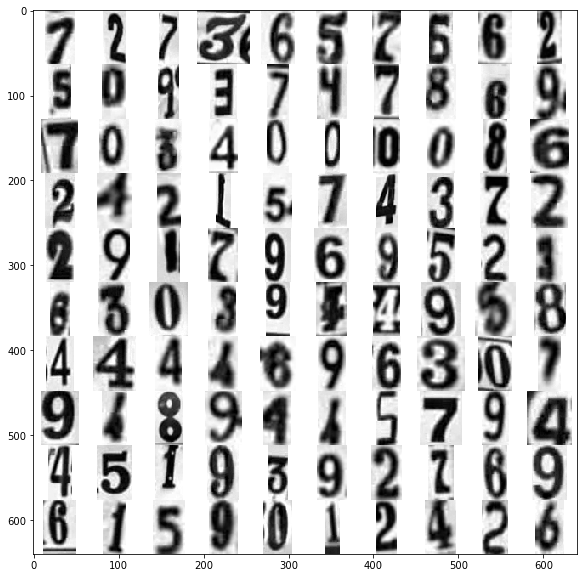

In [1]:
%pylab inline
import matplotlib.image as img
import numpy as np
from sklearn.preprocessing import StandardScaler 

# Load and Visaulize digits data 
data=np.load('data.npz')
train_X=data['train_X']
train_y =data['train_y']
test_X = data['test_X']

train_X=train_X/255
test_X = test_X/255

def gallery(array, ncols):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    result = (array.reshape((nrows, ncols, height, width))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols)))
    return result

ncols = 10
result = gallery(train_X.reshape((35000, 64, 64))[:ncols**2], ncols)

plt.figure(figsize=(10,10))
plt.imshow(result.T, interpolation=None, cmap = 'gray')

In [3]:
#Routine for elapsed time 
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        t= (time.time() - startTime_for_tictoc )/60
        if t> 60:
            tt =t/60
            ttt = np.round(tt)-tt
            ttt = np.round(ttt*60)
            print( "Elapsed time is %0.2f" %(np.round(tt)) +" hr " + str(ttt) +" minutes.")
        else:
            print( "Elapsed time is %0.3f" % (t) + " minutes.")
    else:
        print ("Toc: start time not set")

In [4]:
import numpy as np
from scipy.special import expit
import sys

# Multilayer perceptron algorithm  
class MultilayerPerc(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    
    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.
    
    Reference: This code implemented by Sebastian Raschka. 
    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [12]:
# from sklearn.model_selection import train_test_split
# train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.15, random_state = 0)
# print(train_X.shape, test_X.shape)

(29750, 4096) (5250, 4096)


In [5]:

tic()
mlp = MultilayerPerc(n_output=10, 
                  n_features=train_X.shape[1], 
                  n_hidden=380, 
                  l2=0.03, 
                  l1=0.0, 
                  epochs=1000, 
                  eta=0.002,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=130,
                  shuffle=True,
                  random_state=1)
mlp.fit(train_X, train_y, print_progress = True)
toc()
    

Epoch: 1000/1000

Elapsed time is 4.00 hr 27.0 minutes.


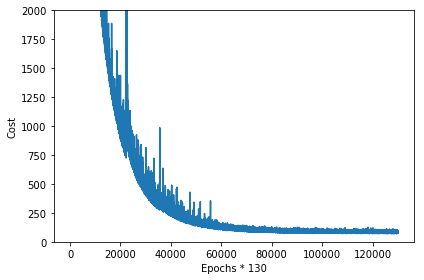

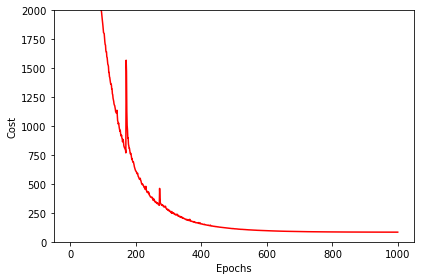

Training accuracy:  99.47%


In [34]:
# Convergence over 130 batches

plt.figure()
plt.plot(range(len(mlp.cost_)), mlp.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 130')
plt.tight_layout()
plt.show()
# plt.savefig('', dpi=300)

# Convergence over averaged batches

no_batches = np.array_split(range(len(mlp.cost_)), 1000)
cost_ary = np.array(mlp.cost_)
Avg_cost = [np.mean(cost_ary[i]) for i in no_batches]
plt.figure()
plt.plot(range(len(Avg_cost)), Avg_cost, color='red')
plt.ylim([0,2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

#Training Accuracy
y_train_pred  = mlp.predict(train_X)
acc = np.sum(train_y == y_train_pred, axis = 0)/train_y.shape[0]
print ('Training accuracy:  %0.2f%%' % (acc* 100))
# Prediction from test data
y_test_pred  = mlp.predict(test_X)
# acc = np.sum(test_y == y_test_pred, axis = 0)/test_y.shape[0]
# print ('Test accuracy:  %0.2f%%' % (acc* 100))

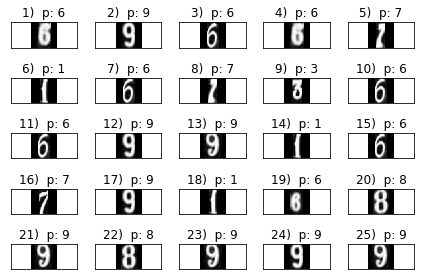

In [33]:
# Show some of images along with predicted labels

miscls = test_X[y_test_pred][:25]
mis= y_test_pred[y_test_pred][:25]
fig, ax = plt.subplots(nrows=5,
ncols=5,
sharex=True,
sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscls[i].reshape(64, 64)
    ax[i].imshow(img.T,
      cmap='Greys',
      interpolation='nearest')
    ax[i].set_title('%d)  p: %d'
      % (i+1,  mis[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


### 2.2. Method Description
Describe your approach, and justify each of the choices made within your approach. You should write a document with no more than 400 words, as a **PDF** file (not *docx* etc) with up to 2 pages of A4 (2 sides). Text must only appear on the first page, while the second page is for *figures and tables only*. Please use a font size of 11pt or higher. Please consider using `pdflatex` for the report, as it's considerably better for this purpose than wysiwyg document editors. You are encouraged to include empirical results, e.g., a table of results, graphs, or other figures to support your argument. *(this will contribute 9 marks; note that we are looking for clear presentation, sound reasoning, good evaluation and error analysis, as well as general ambition of approach.)*